P.S: Since there are 110 corresponding points, it may take a bit to finish.

In [85]:
import cv2
import numpy as np
from scipy.spatial import Delaunay
import matplotlib.pyplot as plt
import imageio

Here we load our images.

In [86]:
img_1 = cv2.imread('res01.png')
img_2 = cv2.imread('res02.png')

Now we extract its dimentions

In [87]:
height, width = img_1.shape[:2]

Here are the main functions that we use for morphing. The backwardmapping function recieves a triangularization and set_of points. For each triangle we pass a Affin Transform matrix which is used for the pixels within that area.
So we iterate over our triangles, gather the points which are inside that triangle and then we use the corresponding Affine Transform matrix to warp the specified area.

In [88]:
simplex = []
for i in range(height):
    for j in range(width):
        simplex.append((i, j))

def sign(p1, p2, p3):
    return (p1[0] - p3[0]) * (p2[1] - p3[1]) - (p2[0] - p3[0]) * (p1[1] - p3[1])


def is_point_in_triangle(p, v1, v2, v3):
    d_1 = sign(p, v1, v3)
    d_2 = sign(p, v2, v3)
    d_3 = sign(p, v1, v2)
    has_neg = d_1 < 0 or d_2 < 0 or d_3 < 0
    has_pos = d_1 > 0 or d_2 > 0 or d_3 > 0

    return not (has_neg and has_pos)

def fast_convex_hull(new_points, tri, last_hull):
    new_hull = last_hull.copy()
    for i in range(height):
        print(i)
        for j in range(width):
            v1, v2, v3 = new_points[tri.simplices[last_hull[i][j]]]
            if is_point_in_triangle([i, j], v1, v2, v3):
                continue
            neighbours = tri.neighbors[last_hull[i][j]]
            neighbours = np.where(neighbours > 0, neighbours, np.max(neighbours))
            unique_neighbors = np.unique(neighbours)
            did_find = False
            for n in unique_neighbors:
                v1, v2, v3 = new_points[tri.simplices[n]]
                if is_point_in_triangle([i, j], v1, v2, v3):
                    new_hull[i][j] = n
                    did_find = True
                    break
            if did_find:
                continue
            for i in range(len(tri.simplices)):
                v1, v2, v3 = new_points[tri.simplices[i]]
                if is_point_in_triangle([i, j], v1, v2, v3):
                    new_hull[i][j] = i
                    break
    return new_hull


def backward_mapping(image_s, image_d, tri, transformations, new_points):
    rows, cols, channels = image_s.shape
    
    simplex_ind = tri.find_simplex(np.array(simplex)).reshape((rows, cols))
    segments = np.unique(simplex_ind)

    for segment in segments:
        k1, k2, k3 = tri.simplices[segment]
        H_matrix = transformations[(k1, k2, k3)]
        image_s[simplex_ind == segment] = cv2.warpAffine(image_d, H_matrix, (cols, rows), flags=2)[simplex_ind == segment]

Here we load the corresponded points for first image. We use 110 points in this example.

In [89]:
file_lines = ''
with open('./points_1.txt', 'r', encoding='UTF8') as f:
    file_lines = f.read().strip().split('\n')

number_of_points = len(file_lines)
points_1 = list()
for i in range(number_of_points):
    x, y = map(float, file_lines[i].split())
    points_1.append((x, y))

Here we load the corresponded points for second image. We use 110 points in this example.

In [90]:
file_lines = ''
with open('./points_2.txt', 'r', encoding='UTF8') as f:
    file_lines = f.read().strip().split('\n')

number_of_points = len(file_lines)
points_2 = list()
for i in range(number_of_points):
    x, y = map(float, file_lines[i].split())
    points_2.append((x, y))

We caclulate the move vector for each corresponding point and find the middle of this process.

In [91]:
points_1, points_2 = np.array(points_1) , np.array(points_2)
move_vector = points_2 - points_1
middle = (points_1 + points_2) / 2

We use SciPy Delaunay function to apply a triangularization on a set of points. Here we do it just for showing the points. because in the main part we apply a delaunay in each middle step.

Here are the loaded points with the given triangularization on the first image.

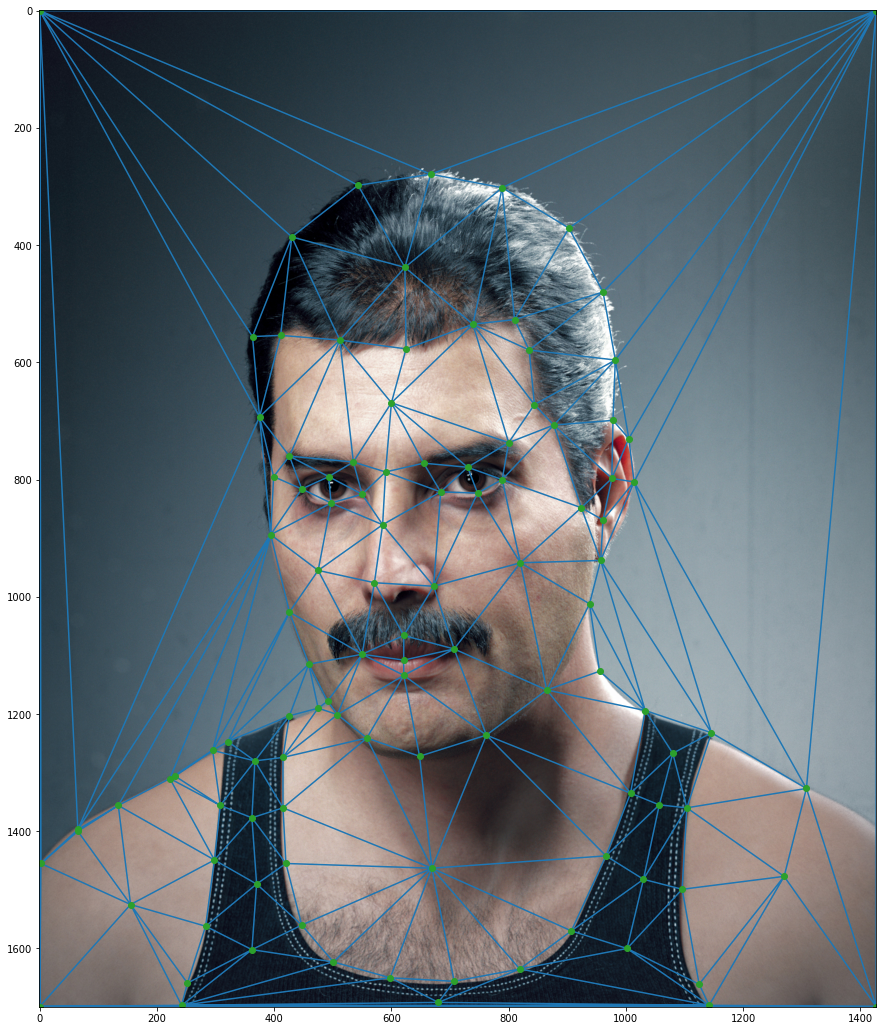

In [92]:
tri = Delaunay(points_1)
fig = plt.figure(figsize=(15, 20))
plt.triplot(points_1[:, 1], points_1[:, 0], tri.simplices)
plt.plot(points_1[:, 1], points_1[:, 0], 'o')
plt.imshow(cv2.cvtColor(img_1, cv2.COLOR_BGR2RGB))
plt.show()

Here are the loaded points with the given triangularization on the second image.

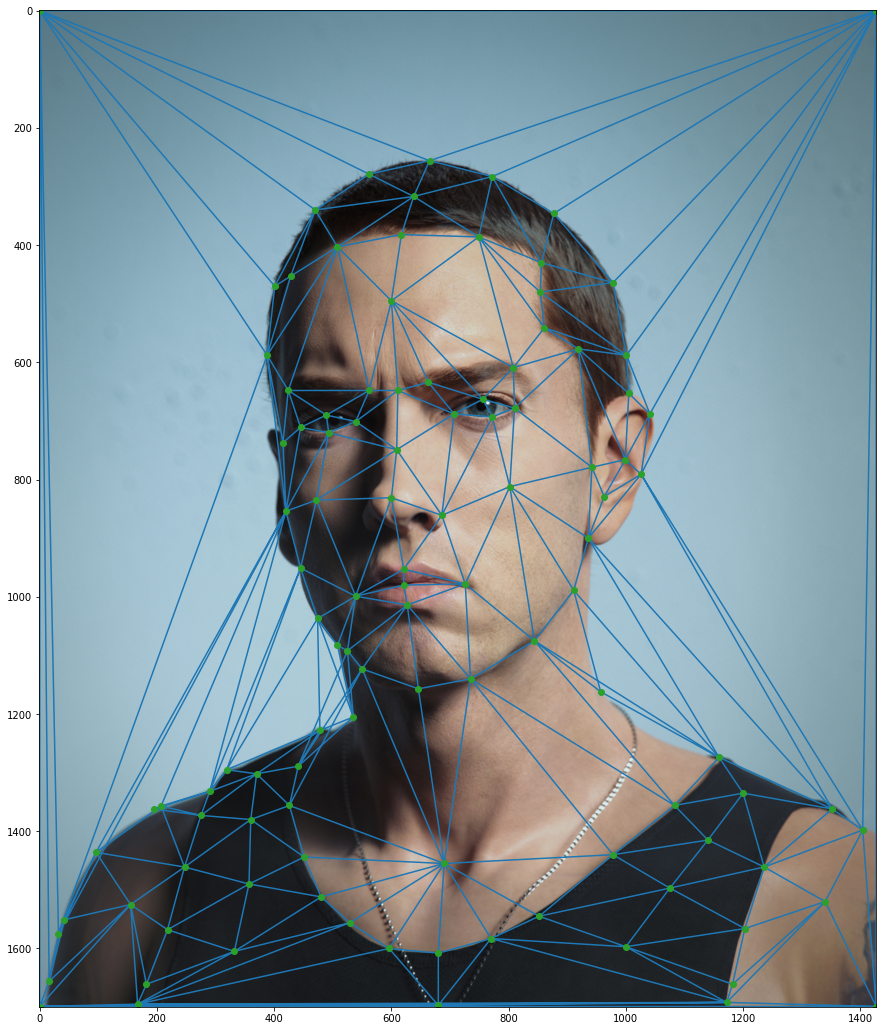

In [93]:
fig = plt.figure(figsize=(15, 20))
plt.triplot(points_2[:, 1], points_2[:, 0], tri.simplices)
plt.plot(points_2[:, 1], points_2[:, 0], 'o')
plt.imshow(cv2.cvtColor(img_2, cv2.COLOR_BGR2RGB))
plt.show()

Now we define quantitize this process by dividing it ot finite number of steps. As we're asked for this assignment, we use 45 steps.

In [94]:
steps = 45

We define the first image sequence and also we provide the t factor, which indicates how long should we move in the move_vector direction.

In [95]:
first_image_sequence = [img_1]
T = np.linspace(0, 1, steps)
Tris = []

Here is the main section. At the begining of each step we calculate the next positions of points. then we look at each triangle and find an affine transform for each of them. We add that matrix to our dictionary so that we can pass that to our backwardmapping function. Each affine transform has a DoF of 6. By having 3 coordinates we can achieve a Affine Transform Matrix. That's because we use triangles for morphing.
In each step we define a new Delaunay. This will cause a computation overhead but the final result will look better. We alse store them to use the same delaunay for second image as well. (in the reverse order)

In [96]:
current_points = points_1
for i, t in enumerate(T):
    transforms = dict()
    new_points = points_1 + t * move_vector
    new_tri = Delaunay(new_points)
    Tris.append(new_tri)
    for triangle in new_tri.simplices:
        x, y, z = triangle
        before = current_points[triangle].astype(np.float32)
        after = new_points[triangle].astype(np.float32)
        before = np.roll(before, shift=1, axis=1)
        after = np.roll(after, shift=1, axis=1)
        transforms[(x, y, z)] = cv2.getAffineTransform(before, after)

    current_points = new_points.copy()
    result = np.zeros(shape=(height, width, 3), dtype=np.float64)
    backward_mapping(result, first_image_sequence[-1], new_tri, transforms, new_points)
    result = result.astype(np.uint8)
    first_image_sequence.append(result)

We just convert the colors from BGR to RGB

In [97]:
for i in range(len(first_image_sequence)):
    first_image_sequence[i] = cv2.cvtColor(first_image_sequence[i], cv2.COLOR_BGR2RGB)

here We basically repeat the same process for the second image in the reverse direction.

In [98]:
second_image_sequence = [img_2]
T = np.linspace(0, 1, steps)

In [99]:
current_points = points_2
i = 200
for i, t in enumerate(T):
    transforms = dict()
    new_points = points_2 - t * move_vector
    new_tri = Tris[-i - 1]
    for triangle in new_tri.simplices:
        x, y, z = triangle
        before = current_points[triangle].astype(np.float32)
        after = new_points[triangle].astype(np.float32)
        before = np.roll(before, shift=1, axis=1)
        after = np.roll(after, shift=1, axis=1)
        transforms[(x, y, z)] = cv2.getAffineTransform(before, after)

    current_points = new_points.copy()
    result = np.zeros(shape=(height, width, 3), dtype=np.float64)
    backward_mapping(result, second_image_sequence[-1], new_tri, transforms, new_points)
    result = result.astype(np.uint8)
    second_image_sequence.append(result)
    i = i + 1

In [100]:
for i in range(len(second_image_sequence)):
    second_image_sequence[i] = cv2.cvtColor(second_image_sequence[i], cv2.COLOR_BGR2RGB)

Now that we have both image sequences, we use cross dissoloving to make a unifed morphing sequence. t goes from 0 to 1 in 45 steps and gradually the image will change.

In [101]:
appended = []
for first, second, t in zip(first_image_sequence, second_image_sequence[::-1], T):
    appended.append(((1 - t) * first + t * second).astype(np.uint8))

We add the reverse order of the list to current list in order to form a loop, so that after watching it, we feel it's infinite.

In [102]:
appended += appended[::-1]

Here we store the 15th and 30th image of this sequnce.

In [103]:
cv2.imwrite('res03.jpg', cv2.cvtColor(appended[14].astype(np.uint8), cv2.COLOR_RGB2BGR))
cv2.imwrite('res04.jpg', cv2.cvtColor(appended[29].astype(np.uint8), cv2.COLOR_RGB2BGR))

True

Now we use imageio to create a video from the sequnce, first one is a 30 fps video which is 3s. The second one is 15fps and 6s.

In [104]:
imageio.mimsave('./morph-3s.mp4', appended, fps=30) # 30 fps
imageio.mimsave('./morph-6s.mp4', appended, fps=15) # 6s

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1428, 1700) to (1440, 1712) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1428, 1700) to (1440, 1712) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
